In [316]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np 
import pandas as pd 
from pandas import Series
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_selection import f_classif, mutual_info_classif
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

from sklearn.metrics import confusion_matrix, plot_confusion_matrix
from sklearn.metrics import auc, roc_auc_score, roc_curve
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score, mean_absolute_error, mean_squared_error, precision_score 

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestRegressor

import datetime
from datetime import datetime, timedelta
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


In [317]:
#PATH_to_file = '/kaggle/input/sf-dst-scoring/'
#train = pd.read_csv(PATH_to_file + 'train.csv')
#test = pd.read_csv(PATH_to_file + 'test.csv')
#sample_submission = pd.read_csv(PATH_to_file + 'sample_submission.csv')

In [318]:
sample_submission = pd.read_csv('sample_submission.csv', encoding = 'ISO-8859-1', low_memory = False)
train = pd.read_csv('train.csv', encoding = 'ISO-8859-1', low_memory = False)
test = pd.read_csv('test.csv', encoding = 'ISO-8859-1', low_memory = False)

In [319]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24354 entries, 0 to 24353
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   client_id  24354 non-null  int64  
 1   default    24354 non-null  float64
dtypes: float64(1), int64(1)
memory usage: 380.7 KB


In [320]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73799 entries, 0 to 73798
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         73799 non-null  int64  
 1   app_date          73799 non-null  object 
 2   education         73492 non-null  object 
 3   sex               73799 non-null  object 
 4   age               73799 non-null  int64  
 5   car               73799 non-null  object 
 6   car_type          73799 non-null  object 
 7   decline_app_cnt   73799 non-null  int64  
 8   good_work         73799 non-null  int64  
 9   score_bki         73799 non-null  float64
 10  bki_request_cnt   73799 non-null  int64  
 11  region_rating     73799 non-null  int64  
 12  home_address      73799 non-null  int64  
 13  work_address      73799 non-null  int64  
 14  income            73799 non-null  int64  
 15  sna               73799 non-null  int64  
 16  first_time        73799 non-null  int64 

In [321]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36349 entries, 0 to 36348
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         36349 non-null  int64  
 1   app_date          36349 non-null  object 
 2   education         36178 non-null  object 
 3   sex               36349 non-null  object 
 4   age               36349 non-null  int64  
 5   car               36349 non-null  object 
 6   car_type          36349 non-null  object 
 7   decline_app_cnt   36349 non-null  int64  
 8   good_work         36349 non-null  int64  
 9   score_bki         36349 non-null  float64
 10  bki_request_cnt   36349 non-null  int64  
 11  region_rating     36349 non-null  int64  
 12  home_address      36349 non-null  int64  
 13  work_address      36349 non-null  int64  
 14  income            36349 non-null  int64  
 15  sna               36349 non-null  int64  
 16  first_time        36349 non-null  int64 

In [245]:
train.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0


In [246]:
# Объединяем train и test данные в один датасет.
train['train'] = 1 # помечаем тренировочные
test['train'] = 0 # помечаем тестовые
df = pd.concat([train, test], ignore_index=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         109670 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [247]:
df.head()

,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,SCH,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,SCH,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,SCH,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,SCH,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,GRD,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


client_id	        идентификатор клиента
app_date            дата добавления
education	        уровень образования
sex	                пол заёмщика
age	                возраст заёмщика
car	                флаг наличия автомобиля
car_type	        флаг автомобиля-иномарки
decline_app_cnt	    количество отказанных прошлых заявок
good_work	        флаг наличия «хорошей» работы
score_bki           оценка кредитной истории
bki_request_cnt  	количество запросов в БКИ
region_rating       региональный рейтинг
home_address	    категоризатор домашнего адреса
work_address	    категоризатор рабочего адреса
income	            доход заёмщика
sna                 связь заемщика с клиентами банка
first_time          степень давности становления заемщиком
foreign_passport	наличие загранпаспорта
default	            наличие дефолта

In [248]:
# Посмотрим количество пропусков

df.isna().sum()

client_id               0
app_date                0
education             478
sex                     0
age                     0
car                     0
car_type                0
decline_app_cnt         0
good_work               0
score_bki               0
bki_request_cnt         0
region_rating           0
home_address            0
work_address            0
income                  0
sna                     0
first_time              0
foreign_passport        0
default             36349
train                   0
dtype: int64

In [249]:
# количество пропусков по столбцам в %, пропусков не много.
for col in df.columns:
    
    
    
    pct_missing = df[col].isna().mean()
    print(f'{col} - {pct_missing :.1%}')

client_id - 0.0%
app_date - 0.0%
education - 0.4%
sex - 0.0%
age - 0.0%
car - 0.0%
car_type - 0.0%
decline_app_cnt - 0.0%
good_work - 0.0%
score_bki - 0.0%
bki_request_cnt - 0.0%
region_rating - 0.0%
home_address - 0.0%
work_address - 0.0%
income - 0.0%
sna - 0.0%
first_time - 0.0%
foreign_passport - 0.0%
default - 33.0%
train - 0.0%


In [250]:
#df.describe()

SCH    57998
GRD    34768
UGR    14748
PGR     1865
ACD      291
Name: education, dtype: int64

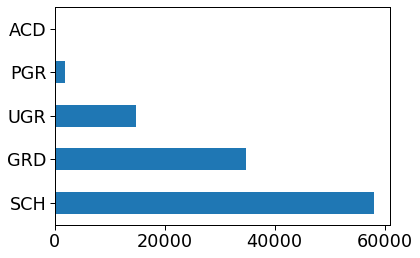

In [251]:
# посморим на распредение переменной education
df['education'].value_counts().plot.barh()
df.education.value_counts()

In [252]:
# заменим пропуски модой
df.education.fillna(df.education.mode()[0], inplace = True)

In [253]:
# проверим
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   app_date          110148 non-null  object 
 2   education         110148 non-null  object 
 3   sex               110148 non-null  object 
 4   age               110148 non-null  int64  
 5   car               110148 non-null  object 
 6   car_type          110148 non-null  object 
 7   decline_app_cnt   110148 non-null  int64  
 8   good_work         110148 non-null  int64  
 9   score_bki         110148 non-null  float64
 10  bki_request_cnt   110148 non-null  int64  
 11  region_rating     110148 non-null  int64  
 12  home_address      110148 non-null  int64  
 13  work_address      110148 non-null  int64  
 14  income            110148 non-null  int64  
 15  sna               110148 non-null  int64  
 16  first_time        11

In [254]:
# Перекодируем значения education в числа
label_encoder = LabelEncoder()

df['education'] = label_encoder.fit_transform(df['education'])
print(dict(enumerate(label_encoder.classes_)))
df.head()

{0: 'ACD', 1: 'GRD', 2: 'PGR', 3: 'SCH', 4: 'UGR'}


,client_id,app_date,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train
0,25905,01FEB2014,3,M,62,Y,Y,0,0,-2.008753,1,50,1,2,18000,4,1,N,0.0,1
1,63161,12MAR2014,3,F,59,N,N,0,0,-1.532276,3,50,2,3,19000,4,1,N,0.0,1
2,25887,01FEB2014,3,M,25,Y,N,2,0,-1.408142,1,80,1,2,30000,1,4,Y,0.0,1
3,16222,23JAN2014,3,F,53,N,N,0,0,-2.057471,2,50,2,3,10000,1,3,N,0.0,1
4,101655,18APR2014,1,M,48,N,N,0,1,-1.244723,1,60,2,3,30000,1,4,Y,0.0,1


In [255]:
# Переведем дату в удобный вид
df['ap_date'] = df['app_date'].apply(pd.Timestamp)

In [256]:
# удалим старую дату
df.drop(['app_date'], inplace = True, axis = 1)

In [257]:
# Добавим признаки года, месяца, дня
df['year'] = df.ap_date.dt.year
df['month'] = df.ap_date.dt.month
df['day'] = df.ap_date.dt.day


In [258]:
# Количество дней, прошедших с начала наблюдений:
df['count_days'] = (df.ap_date - df.ap_date.min()).dt.days

In [259]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,sna,first_time,foreign_passport,default,train,ap_date,year,month,day,count_days
0,25905,3,M,62,Y,Y,0,0,-2.008753,1,...,4,1,N,0.0,1,2014-02-01,2014,2,1,31
1,63161,3,F,59,N,N,0,0,-1.532276,3,...,4,1,N,0.0,1,2014-03-12,2014,3,12,70
2,25887,3,M,25,Y,N,2,0,-1.408142,1,...,1,4,Y,0.0,1,2014-02-01,2014,2,1,31
3,16222,3,F,53,N,N,0,0,-2.057471,2,...,1,3,N,0.0,1,2014-01-23,2014,1,23,22
4,101655,1,M,48,N,N,0,1,-1.244723,1,...,1,4,Y,0.0,1,2014-04-18,2014,4,18,107


In [260]:
# Помотрим на год
df.year.value_counts()

2014    110148
Name: year, dtype: int64

In [261]:
# Год везде один, удалим колонку
df.drop(['year'], inplace = True, axis = 1)

In [262]:
# Помотрим что с месяцами
df.month.value_counts()

3    31597
2    27097
4    26266
1    25188
Name: month, dtype: int64

In [263]:
# Количество дней с начала записей:
df['count_days'] = (df.ap_date - df.ap_date.min()).dt.days

In [264]:
# Дата тоже больше не нужна

df.drop(['ap_date'], inplace = True, axis = 1)

In [265]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,...,work_address,income,sna,first_time,foreign_passport,default,train,month,day,count_days
0,25905,3,M,62,Y,Y,0,0,-2.008753,1,...,2,18000,4,1,N,0.0,1,2,1,31
1,63161,3,F,59,N,N,0,0,-1.532276,3,...,3,19000,4,1,N,0.0,1,3,12,70
2,25887,3,M,25,Y,N,2,0,-1.408142,1,...,2,30000,1,4,Y,0.0,1,2,1,31
3,16222,3,F,53,N,N,0,0,-2.057471,2,...,3,10000,1,3,N,0.0,1,1,23,22
4,101655,1,M,48,N,N,0,1,-1.244723,1,...,3,30000,1,4,Y,0.0,1,4,18,107


In [266]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 22 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int32  
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

<AxesSubplot:>

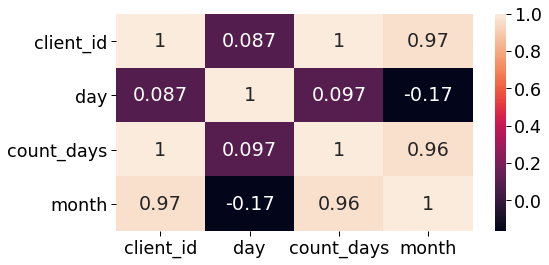

In [267]:
# Посмотрим корреляцию новых признаков и client_id  
dif_cols = ['client_id', 'day', 'count_days', 'month']
plt.figure(figsize=(8,4))
#sns.heatmap(df.iloc[:,19:].corr(), annot=True)
sns.heatmap(df[dif_cols].corr(), annot=True)

In [268]:
# исключим месяцы и count_days
df.drop(['month'], inplace = True, axis = 1)
df.drop(['count_days'], inplace = True, axis = 1)

In [269]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 20 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int32  
 2   sex               110148 non-null  object 
 3   age               110148 non-null  int64  
 4   car               110148 non-null  object 
 5   car_type          110148 non-null  object 
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

In [270]:
# Разделим наши признаки на числовые, бинарные и категорийные
num_cols = ['age', 'day', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']
bin_cols = ['sex', 'car', 'car_type', 'foreign_passport', 'good_work']
cat_cols = ['education', 'home_address', 'work_address', 'sna', 'first_time', 'region_rating']


In [271]:
# Применим LabelEncoder к бинарным переменным
label_encoder = LabelEncoder()

for column in bin_cols:
    df[column] = label_encoder.fit_transform(df[column])
    

In [272]:
df.head()

,client_id,education,sex,age,car,car_type,decline_app_cnt,good_work,score_bki,bki_request_cnt,region_rating,home_address,work_address,income,sna,first_time,foreign_passport,default,train,day
0,25905,3,1,62,1,1,0,0,-2.008753,1,50,1,2,18000,4,1,0,0.0,1,1
1,63161,3,0,59,0,0,0,0,-1.532276,3,50,2,3,19000,4,1,0,0.0,1,12
2,25887,3,1,25,1,0,2,0,-1.408142,1,80,1,2,30000,1,4,1,0.0,1,1
3,16222,3,0,53,0,0,0,0,-2.057471,2,50,2,3,10000,1,3,0,0.0,1,23
4,101655,1,1,48,0,0,0,1,-1.244723,1,60,2,3,30000,1,4,1,0.0,1,18


In [273]:
# разделим датасет на тест и трейн.
train_n = df.query('train == 1').drop(['train'], axis=1)
test_n = df.query('train == 0').drop(['train'], axis=1)

In [274]:
# наивная модель
X = train_n.drop(['default'], axis = 1).values
Y = train_n['default'].values
X_train, X_test, y_train, y_test = train_test_split(X,Y, test_size= 0.2, random_state=42)

In [275]:
model_n = LogisticRegression(max_iter = 100)
model_n.fit(X_train, y_train)
y_pred = model_n.predict(X_test)


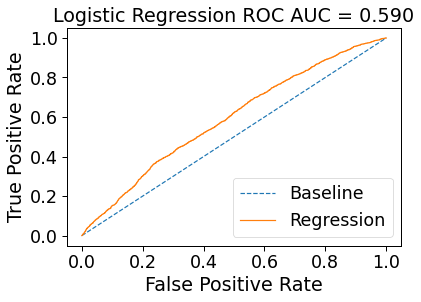

In [276]:
probs = model_n.predict_proba(X_test)
probs = probs[:,1]

fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

In [277]:
# Оценка качества:
print('accuracy_score: {}'.format(np.round(accuracy_score(y_test, y_pred), 3)))
print('f1_score: {}'.format(np.round(f1_score(y_test, y_pred), 3)))
print('recall_score: {}'.format(np.round(recall_score(y_test, y_pred), 3)))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, y_pred), 3)))

accuracy_score: 0.876
f1_score: 0.0
recall_score: 0.0
MSE: 0.124


<AxesSubplot:>

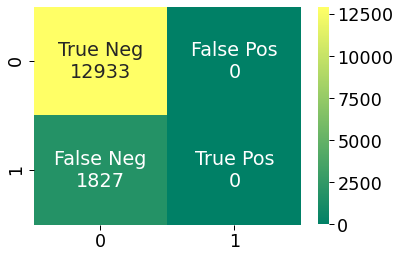

In [278]:
# Визуализация confusion matrix:
sns.set_context(context='paper', font_scale=2, rc=None)
group_names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
group_counts = ['{0:0.0f}'.format(value) for value in
                confusion_matrix(y_test, y_pred).flatten()]
labels = [f'{v1}\n{v2}' for v1, v2 in
          zip(group_names, group_counts)]
labels = np.asarray(labels).reshape(2, 2)
sns.heatmap(confusion_matrix(y_test, y_pred), annot=labels, fmt='', cmap='summer')

0.0    64427
1.0     9372
Name: default, dtype: int64

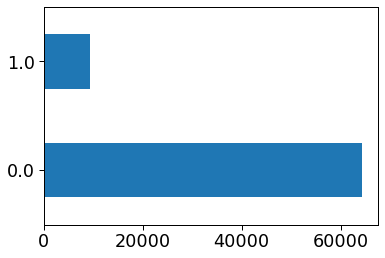

In [279]:
# посмотрим на распередение целевой переменной
df['default'].value_counts().plot.barh()
df.default.value_counts()

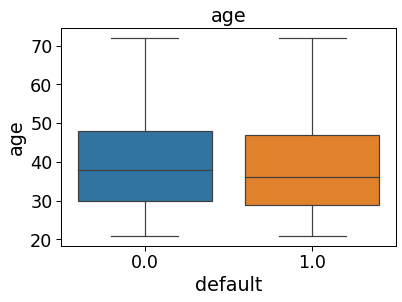

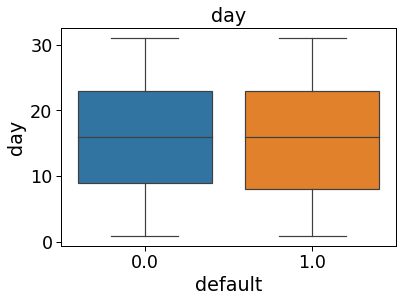

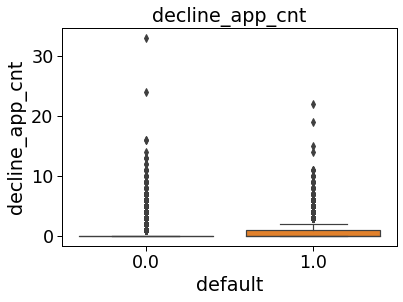

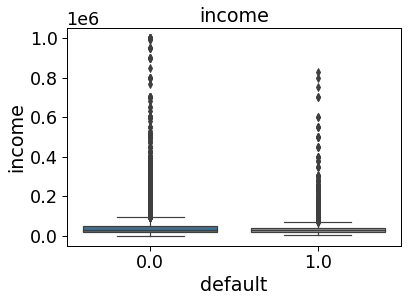

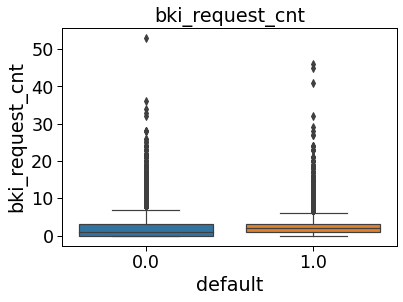

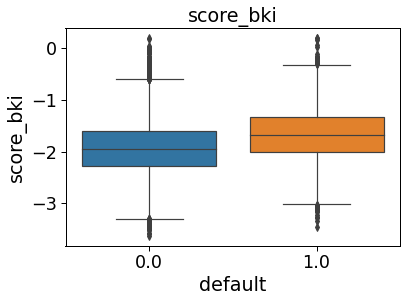

In [280]:
# построим и рассмотрим боксплоты 
data = df.copy()
for i in num_cols:
    plt.figure()
    sns.boxplot(x='default', y = i, data=data)
    plt.title(i)

In [281]:
# День можно исключить из признаков и из списка числовых признаков.
df.drop(['day'], axis=1, inplace=True)
num_cols.remove('day')

In [282]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110148 entries, 0 to 110147
Data columns (total 19 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   client_id         110148 non-null  int64  
 1   education         110148 non-null  int32  
 2   sex               110148 non-null  int32  
 3   age               110148 non-null  int64  
 4   car               110148 non-null  int32  
 5   car_type          110148 non-null  int32  
 6   decline_app_cnt   110148 non-null  int64  
 7   good_work         110148 non-null  int64  
 8   score_bki         110148 non-null  float64
 9   bki_request_cnt   110148 non-null  int64  
 10  region_rating     110148 non-null  int64  
 11  home_address      110148 non-null  int64  
 12  work_address      110148 non-null  int64  
 13  income            110148 non-null  int64  
 14  sna               110148 non-null  int64  
 15  first_time        110148 non-null  int64  
 16  foreign_passport  11

<AxesSubplot:>

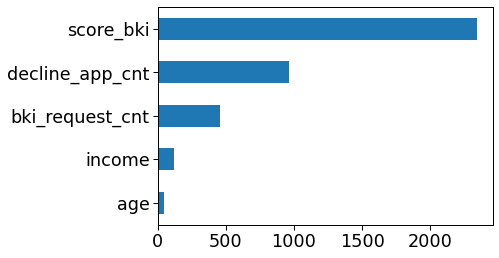

In [283]:
# посмотрим как числовые признаки влияют на целевую переменную
num_df = df[df['train'] == 1]
imp_num = Series(f_classif(num_df[num_cols], num_df['default'])[0], index = num_cols)
imp_num.sort_values(inplace = True)
imp_num.plot(kind = 'barh')

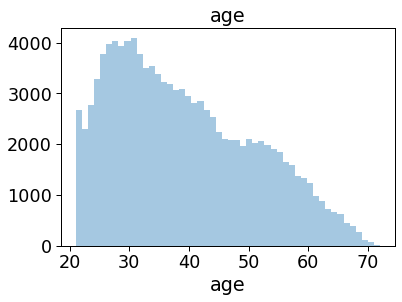

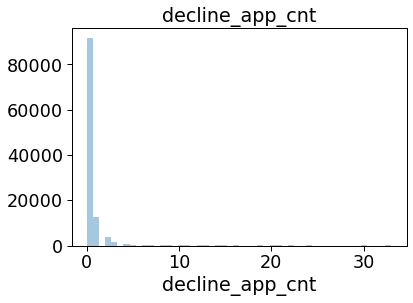

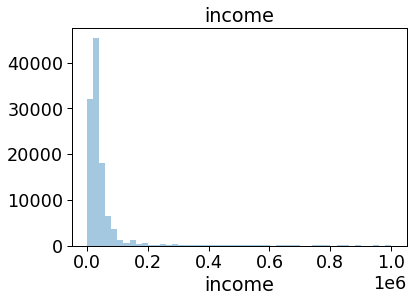

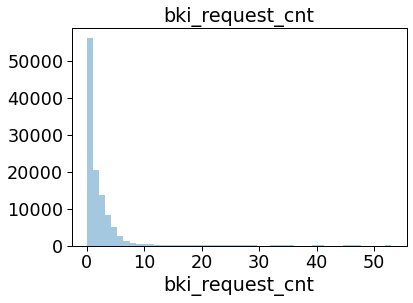

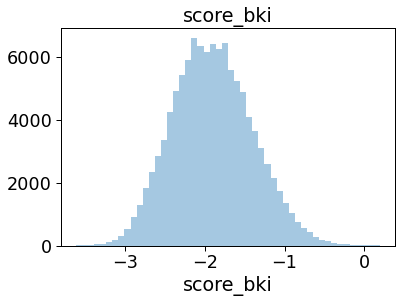

In [285]:
# Построим графики распределения числовых переменных
for i in num_cols:
    plt.figure()
    
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()
    

In [286]:
num_cols

['age', 'decline_app_cnt', 'income', 'bki_request_cnt', 'score_bki']

score_bki имеет нормальное распределение

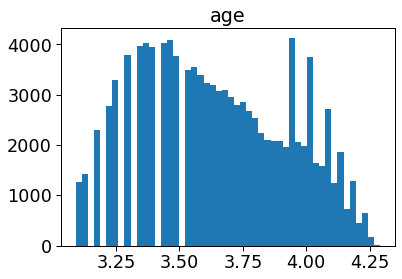

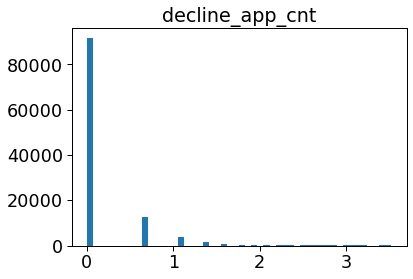

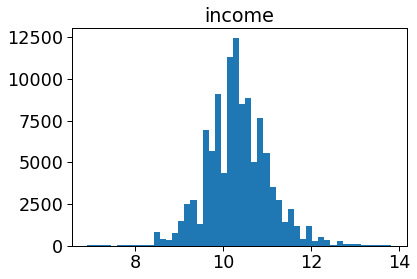

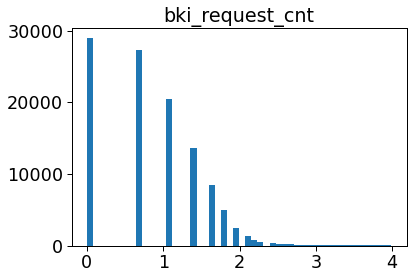

In [287]:
# прологарифмируем остальные числовые признаки
num_cols1 = ['age', 'decline_app_cnt', 'income', 'bki_request_cnt']
for i in num_cols1:
    plt.figure()
   
    df[i] = df[i].apply(lambda w: np.log(w + 1))
    plt.hist(df[i], bins=50);
   
    plt.title(i)
    plt.show()
    

In [288]:
# результат есть только для признака income

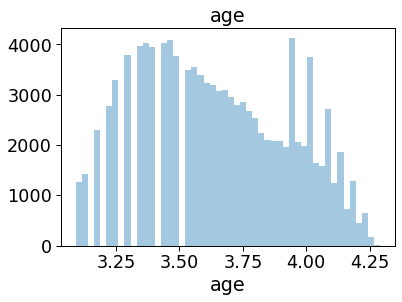

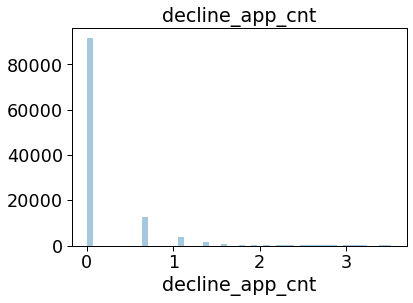

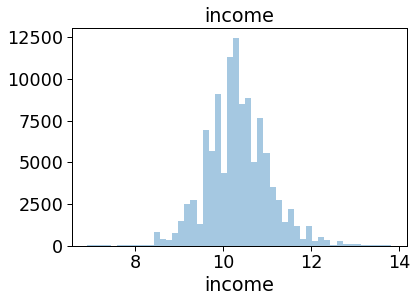

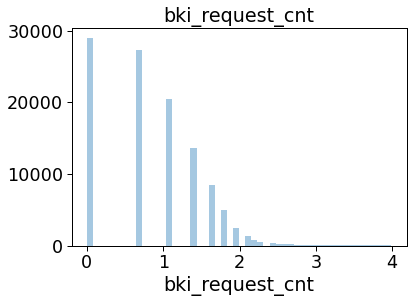

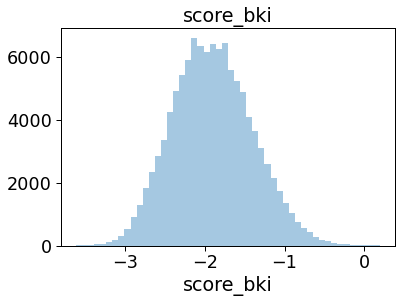

In [289]:
# проверим, что получилось 


for i in num_cols:
    plt.figure()
    sns.distplot(df[i], kde=False, rug=False)
    plt.title(i)
    plt.show()

<AxesSubplot:>

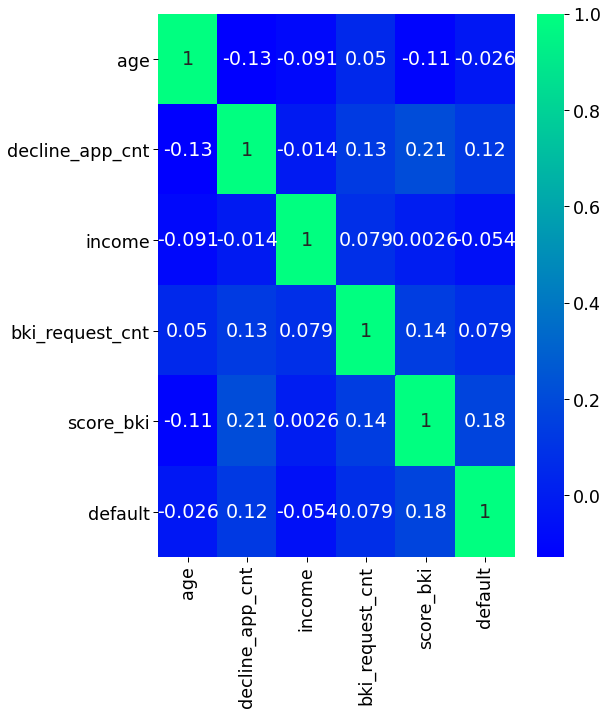

In [290]:
# построим матрицу корреляций для числовых признаков
plt.figure(figsize=(8,10))
sns.heatmap(df[num_cols+['default']].corr(), cmap='winter', annot=True)

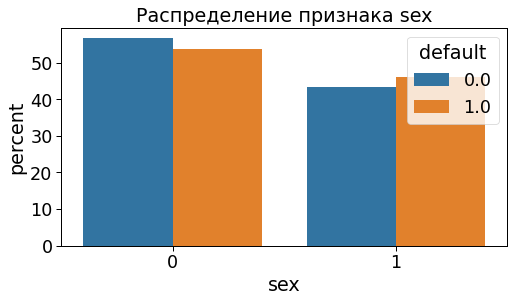

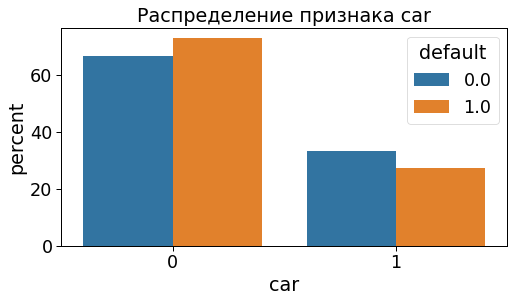

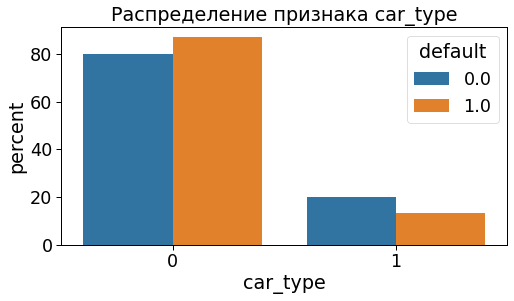

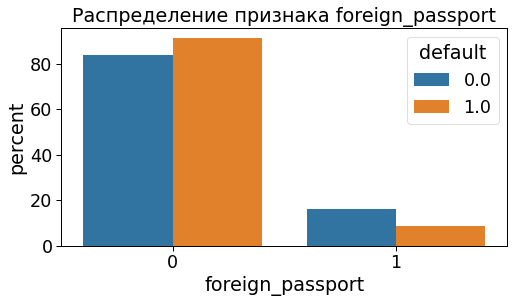

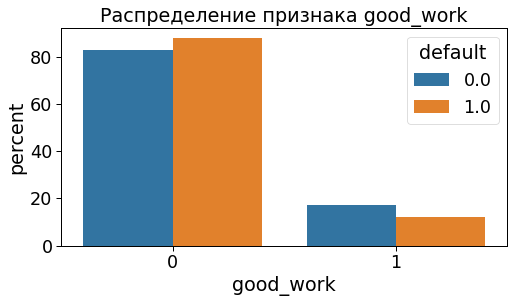

In [291]:
# Построим графики распределения бинарных переменных по соотношению с default:
for col in bin_cols:
    plt.figure(figsize=(8, 4))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

<AxesSubplot:>

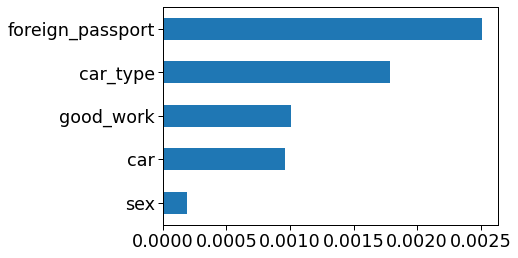

In [292]:
# Проверим значимость бинарных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[bin_cols],
                 temp_df['default'], discrete_features=True),
                 index=bin_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

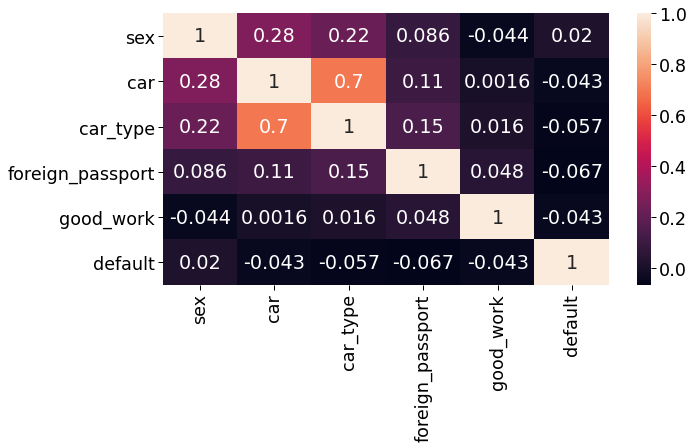

In [293]:
# Построим матрицу корреляций для бинарных признаков:
plt.figure(figsize=(10,5))
sns.heatmap(df[bin_cols+['default']].corr(), annot=True)

больше других коррелируют car и car_type оставим оба.

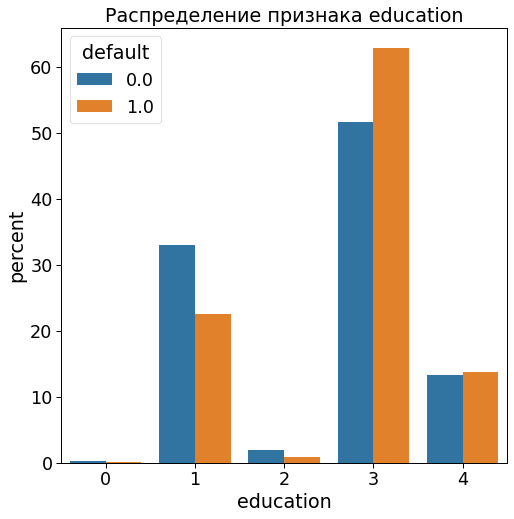

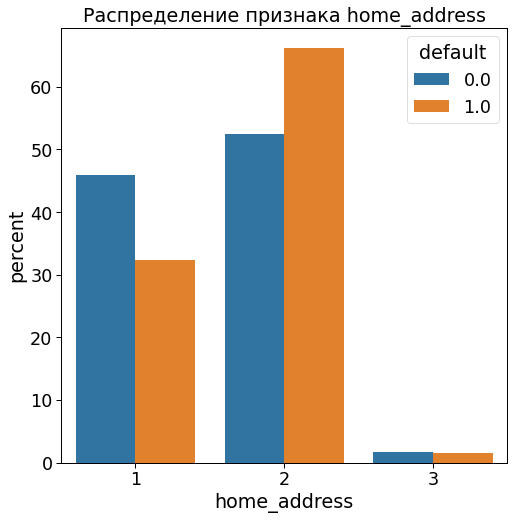

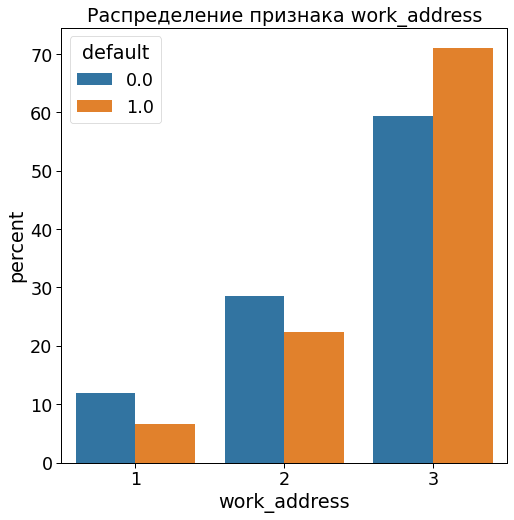

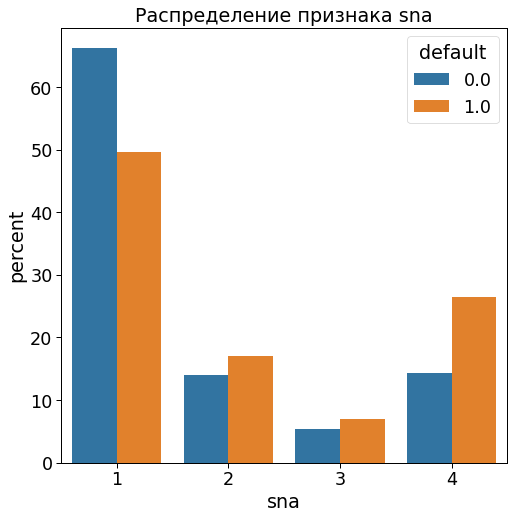

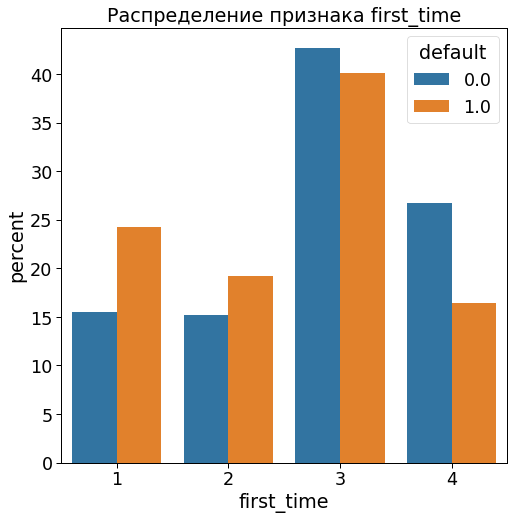

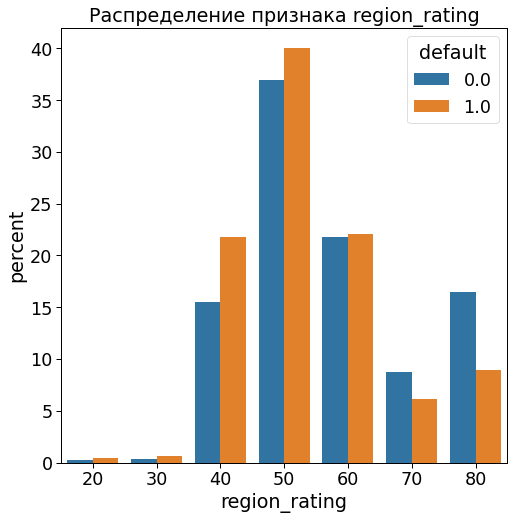

In [294]:
# Построим графики распределения значений посоотношению с default:
for col in cat_cols:
    plt.figure(figsize=(8,8))
    prop_df = df[col].groupby(df["default"]).value_counts(
        normalize=True).rename("percent").reset_index()
    prop_df["percent"] *= 100
    sns.barplot(x=col, y="percent", hue="default", data=prop_df)
    plt.title(f"Распределение признака {col}")

<AxesSubplot:>

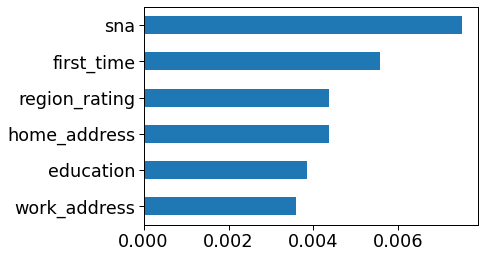

In [295]:
# Проверим значимость категориальных переменных:
temp_df = df[df['train'] == 1]
imp_cat = Series(mutual_info_classif(temp_df[cat_cols],
                 temp_df['default'], discrete_features=True),
                 index=cat_cols)
imp_cat.sort_values(inplace=True)
imp_cat.plot(kind='barh')

<AxesSubplot:>

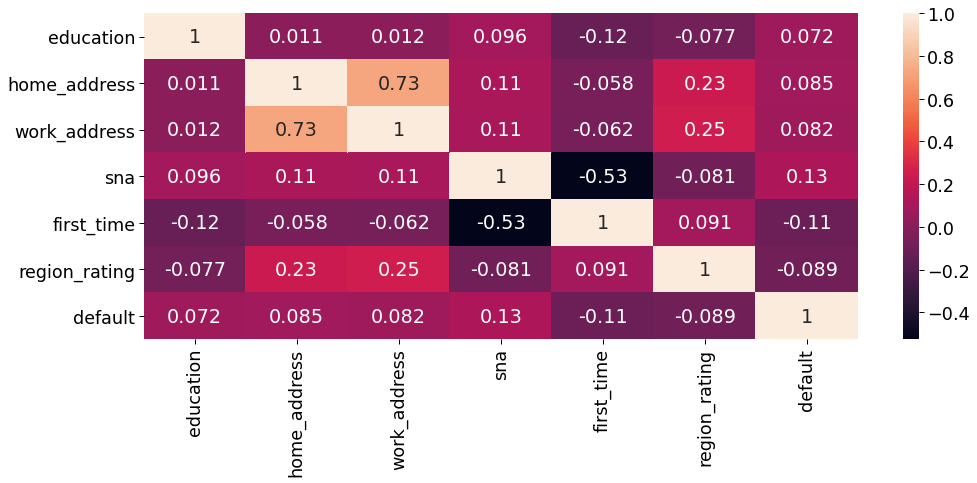

In [296]:
# Построим матрицу корреляций для категориальных признаков:
plt.figure(figsize=(16,6))
sns.heatmap(df[cat_cols+['default']].corr(), annot=True)

<AxesSubplot:>

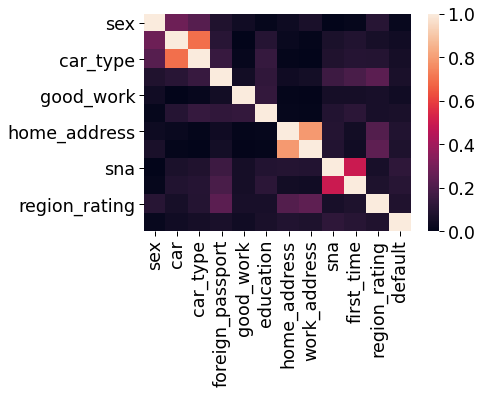

In [297]:
# посмотрим как бинарные и категорийные признаки коррелируют между собой и с целевой переменной
sns.heatmap(df[bin_cols + cat_cols + ['default']].corr(method='spearman').abs(), vmin=0, vmax=1)

 Строим модель

In [298]:
# Делим датасет обратно - на тест и трейн.
train = df.query('train == 1').drop(['train'], axis=1)
test = df.query('train == 0').drop(['train'], axis=1)

In [299]:
# Разбиваем кагориальные переменные на 0 и 1
X_cat = OneHotEncoder(sparse = False).fit_transform(train[cat_cols].values)

In [300]:

X_cat.shape

(73799, 26)

In [301]:
# Стандартизация числовых переменных

X_num = StandardScaler().fit_transform(train[num_cols].values)

Объединим стандартизованные числовые, бинарные и закодированные категориальные переменные в одно признаковое пространство, разделив при этом признаки и целевую переменную.

In [302]:
# Объединяем

X = np.hstack([X_num, train[bin_cols].values, X_cat])
Y = train['default'].values

Подготовка признаков для модели завершена. Разделим данные для обучения:

In [303]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.20, random_state=42)


Создадим и обучим первую модель на стандартных настройках логистической регрессии

In [304]:
model_1 = LogisticRegression(max_iter=1000, random_state=42)
model_1.fit(X_train, y_train)


LogisticRegression(max_iter=1000, random_state=42)

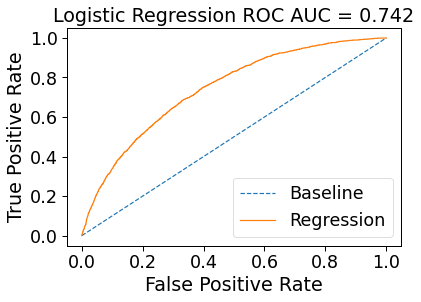

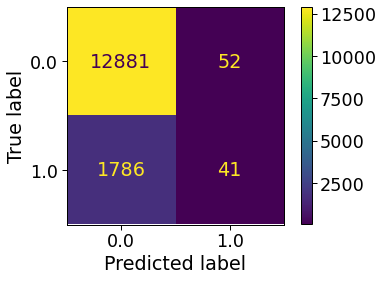

In [305]:
probs = model_1.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()

plot_confusion_matrix(model_1, X_test, y_test)  
plt.show()

In [306]:
preds = model_1.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, preds))
print('Precision: %.3f' % precision_score(y_test, preds))
print('Recall: %.3f' % recall_score(y_test, preds))
print('F1: %.3f' % f1_score(y_test, preds))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, preds), 3)))

Accuracy: 0.875
Precision: 0.441
Recall: 0.022
F1: 0.043
MSE: 0.125


Найдем оптимальное значение параметра регуляризации для логистической регрессии.
Произведем поиск гиперпараметров GridSearchCV при помощи перебора параметров по сетке с последующей кросс-валидацией.

In [307]:
from sklearn.model_selection import GridSearchCV

# Добавим типы регуляризации
penalty = ['l1', 'l2']

# Зададим ограничения для параметра регуляризации
C = np.logspace(0, 4, 10)

# Создадим гиперпараметры
hyperparameters = dict(C=C, penalty=penalty)

model = LogisticRegression(solver = 'liblinear', max_iter = 500)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Создаем сетку поиска с использованием 5-кратной перекрестной проверки
clf = GridSearchCV(model, hyperparameters, cv=5, verbose=0)

best_model = clf.fit(X_train, y_train)

# View best hyperparameters
print('Лучшее Penalty:', best_model.best_estimator_.get_params()['penalty'])
print('Лучшее C:', best_model.best_estimator_.get_params()['C'])

Лучшее Penalty: l1
Лучшее C: 1.0


In [308]:
# GridSearchCV - Настройка гиперпараметров поиском по сетке
from sklearn.linear_model import LogisticRegressionCV
model = LogisticRegression(random_state=42)

param_grid = [
    {'penalty': ['l1'], 
     'solver': ['liblinear', 'lbfgs'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
    'max_iter':[100]}, 
    {'penalty': ['l2'], 
     'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
    'max_iter':[100]}, 
    {'penalty': ['none'], 
     'solver': ['newton-cg', 'lbfgs', 'sag', 'saga'], 
     'class_weight':['none', 'balanced'], 
     'multi_class': ['auto','ovr'],
    'max_iter':[100]} 
]
gridsearch = GridSearchCV(model, param_grid, scoring='f1', n_jobs=-1)
gridsearch.fit(X_train, y_train)
model = gridsearch.best_estimator_
## печатаем параметры
best_parameters = model.get_params()
best_parameters

{'C': 1.0,
 'class_weight': 'balanced',
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 100,
 'multi_class': 'auto',
 'n_jobs': None,
 'penalty': 'none',
 'random_state': 42,
 'solver': 'newton-cg',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [309]:
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, preds))
print('Precision: %.3f' % precision_score(y_test, preds))
print('Recall: %.3f' % recall_score(y_test, preds))
print('F1: %.3f' % f1_score(y_test, preds))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, preds), 3)))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.666
Precision: 0.224
Recall: 0.688
F1: 0.338
MSE: 0.334


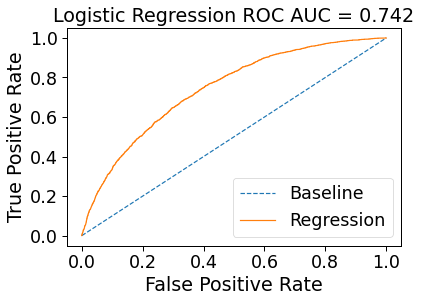

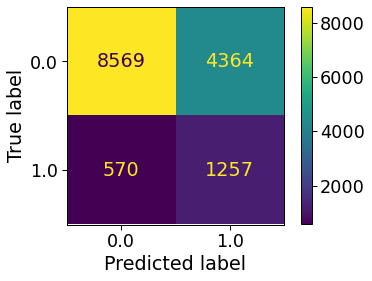

In [310]:
model = LogisticRegression(max_iter=1000, C=1, 
 class_weight='balanced',
 dual=False,
 fit_intercept=True,
 intercept_scaling=1,
 l1_ratio=None,
 multi_class='auto',
 n_jobs=None,
 penalty='none',
 random_state=42,
 solver='newton-cg',
 tol=0.0001,
 verbose=0,
 warm_start=False)
model.fit(X_train, y_train)

probs = model.predict_proba(X_test)
probs = probs[:,1]


fpr, tpr, threshold = roc_curve(y_test, probs)
roc_auc = roc_auc_score(y_test, probs)

plt.figure()
plt.plot([0, 1], label='Baseline', linestyle='--')
plt.plot(fpr, tpr, label = 'Regression')
plt.title('Logistic Regression ROC AUC = %0.3f' % roc_auc)
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc = 'lower right')
plt.show()
plot_confusion_matrix(model, X_test, y_test)  
plt.show()

In [311]:
for param_name in sorted(best_parameters.keys()):
        print('\t%s: %r' % (param_name, best_parameters[param_name]))
    ##печатаем метрики
preds = model.predict(X_test)
print('Accuracy: %.3f' % accuracy_score(y_test, preds))
print('Precision: %.3f' % precision_score(y_test, preds))
print('Recall: %.3f' % recall_score(y_test, preds))
print('F1: %.3f' % f1_score(y_test, preds))
print('MSE: {}'.format(np.round(mean_squared_error(y_test, preds), 3)))

	C: 1.0
	class_weight: 'balanced'
	dual: False
	fit_intercept: True
	intercept_scaling: 1
	l1_ratio: None
	max_iter: 100
	multi_class: 'auto'
	n_jobs: None
	penalty: 'none'
	random_state: 42
	solver: 'newton-cg'
	tol: 0.0001
	verbose: 0
	warm_start: False
Accuracy: 0.666
Precision: 0.224
Recall: 0.688
F1: 0.338
MSE: 0.334


Обрабатываем тестовую выборку, загружаем в модель и готовим submission

In [312]:
X_cat_test = OneHotEncoder(sparse = False).fit_transform(test[cat_cols].values)
X_num_test = StandardScaler().fit_transform(test[num_cols].values)

X_test_test = np.hstack([X_num_test, test[bin_cols].values, X_cat_test])
y_probs = model.predict_proba(X_test_test)[:,1]

In [313]:
test['default'] = y_probs

In [314]:
submission = test[['client_id','default']]
display(submission.head(10))
display(submission.shape)

,client_id,default
73799,74835,0.223002
73800,17527,0.773677
73801,75683,0.329693
73802,26883,0.391241
73803,28862,0.122738
73804,99881,0.638306
73805,26630,0.784585
73806,79934,0.210440
73807,16605,0.111845
73808,105449,0.170894


(36349, 2)

In [315]:
submission.to_csv('submission.csv', index=False)